In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import sys; sys.path.append("src/")
from models import AutoregTheoryModel
from my_datasets import \
    hot, AutoregDataset, FactAmnesiaDataset, SuppressRuleDataset, CoerceStateDataset
from exp_utils import load_model_and_dataset

In [2]:
# Directory and device setup
saveto_dir = "_dump"
models_dir = "_saved_models"
device = "cuda" if torch.cuda.is_available() else "cpu"
do_ln = False

In [3]:
@torch.no_grad()
def run_one_fact_amensia_attack(
    num_props,
    kappa = 1,
    num_repeats = 1,
    num_samples = 16384,
    batch_size = 4096,
    verbose = True,
):
    assert num_samples % batch_size == 0
    n, k, bsz = num_props, num_repeats, batch_size
    zn = torch.zeros(bsz,1,n,device=device)
    model, _ = load_model_and_dataset(n, 2*n, num_samples, models_dir)
    model.eval().to(device)
    dataloader = DataLoader(FactAmnesiaDataset(n,k,num_samples), bsz)
    elems_acc, state_acc, simple_ssr = [], [], [] # Stats to track
    pbar = tqdm(dataloader) if verbose else dataloader
    for batch in pbar:
        a = batch["infos"][:,0:1].to(device)
        init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)
        atk_rule = torch.cat([zn, -kappa*hot(a,n)], dim=-1).view(bsz,1,2*n)
        adv_suffix = torch.cat([atk_rule.repeat(1,k,1), init_token], dim=1)
        all_tokens = torch.cat([batch["tokens"].to(device), adv_suffix], dim=1)
        pred = (model(all_tokens).logits > 0).long()
        s_asr = (pred * hot(a,n).view(-1,1,n)).sum(dim=(1,2)) == 0
        simple_ssr.append(s_asr.float().mean().item())
        if verbose:
            pbar.set_description(f"n {num_props}, kappa {kappa}, ssr {torch.tensor(simple_ssr).mean():.3f}")

    simple_ssr = torch.tensor(simple_ssr).float().mean().item()
    return {"simple_ssr": simple_ssr}

In [4]:
fa_kappas = list(range(1,9))
# fa_kappas = [1, 2, 4, 8, 16, 32, 64, 128]
fa_ret_16 = [run_one_fact_amensia_attack(16, kappa) for kappa in fa_kappas]
fa_ret_32 = [run_one_fact_amensia_attack(32, kappa) for kappa in fa_kappas]
fa_ret_48 = [run_one_fact_amensia_attack(48, kappa) for kappa in fa_kappas]
fa_ret_64 = [run_one_fact_amensia_attack(64, kappa) for kappa in fa_kappas]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x7ef7d4dde620>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8')])

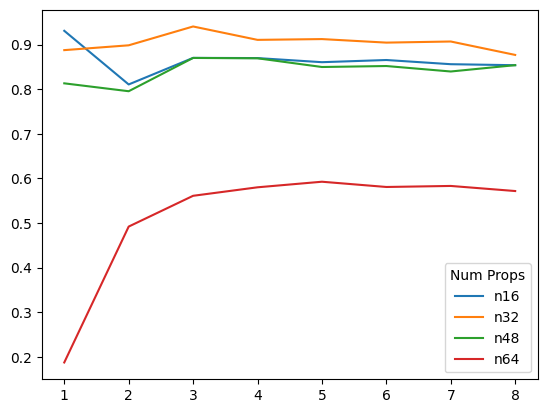

In [5]:
plt.clf()
plt.plot([r["simple_ssr"] for r in fa_ret_16], label="n16")
plt.plot([r["simple_ssr"] for r in fa_ret_32], label="n32")
plt.plot([r["simple_ssr"] for r in fa_ret_48], label="n48")
plt.plot([r["simple_ssr"] for r in fa_ret_64], label="n64")
plt.legend(title="Num Props", loc="lower right")

plt.xticks(list(range(len(fa_kappas))), labels=[str(k) for k in fa_kappas]);

In [6]:
@torch.no_grad()
def run_one_suppress_rule_attack(
    num_props,
    kappa = 1,
    num_repeats = 1,
    num_samples = 16384,
    batch_size = 2048,
    verbose = True,
):
    assert num_samples % batch_size == 0
    n, k, bsz = num_props, num_repeats, batch_size
    zn = torch.zeros(bsz,1,n,device=device)
    model, _ = load_model_and_dataset(n, 2*n, num_samples, models_dir)
    model.eval().to(device)
    dataloader = DataLoader(SuppressRuleDataset(n,k,num_samples), bsz)
    elems_acc, state_acc, simple_ssr = [], [], [] # Stats to track
    pbar = tqdm(dataloader) if verbose else dataloader
    for batch in dataloader:
        infos = batch["infos"].to(device)
        a, b, c, d, e, f, g, h = infos.chunk(infos.size(-1), dim=-1)
        init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)
        atk_rule = torch.cat([hot(c,n)+hot(d,n), -kappa*hot(f,n)], dim=-1).view(bsz,1,2*n)
        adv_suffix = torch.cat([atk_rule.repeat(1,k,1), init_token], dim=1)
        all_tokens = torch.cat([batch["tokens"].to(device), adv_suffix], dim=1)
        pred = (model(all_tokens).logits > 0).long()
        s_asr = (pred * hot(f,n).view(-1,1,n)).sum(dim=(1,2)) == 0
        simple_ssr.append(s_asr.float().mean().item())
        if verbose:
            pbar.set_description(f"n {num_props}, kappa {kappa}, ssr {torch.tensor(simple_ssr).mean():.3f}")

    simple_ssr = torch.tensor(simple_ssr).float().mean().item()
    return {"simple_ssr": simple_ssr}

In [7]:
sr_kappas = list(range(1,9))
sr_ret_16 = [run_one_suppress_rule_attack(16, k) for k in sr_kappas]
sr_ret_32 = [run_one_suppress_rule_attack(32, k) for k in sr_kappas]
sr_ret_48 = [run_one_suppress_rule_attack(48, k) for k in sr_kappas]
sr_ret_64 = [run_one_suppress_rule_attack(64, k) for k in sr_kappas]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x7ef7cf980ee0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8')])

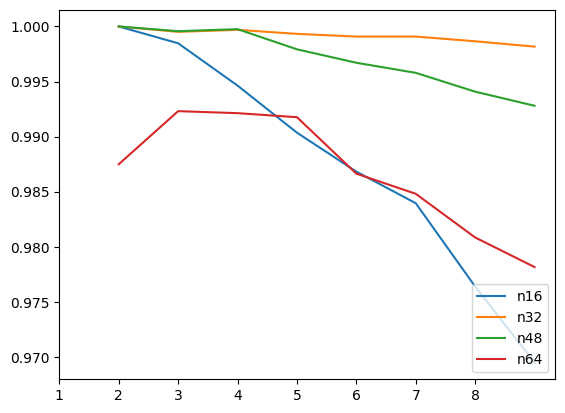

In [8]:
plt.clf()
plt.plot(sr_kappas, [r["simple_ssr"] for r in sr_ret_16], label="n16")
plt.plot(sr_kappas, [r["simple_ssr"] for r in sr_ret_32], label="n32")
plt.plot(sr_kappas, [r["simple_ssr"] for r in sr_ret_48], label="n48")
plt.plot(sr_kappas, [r["simple_ssr"] for r in sr_ret_64], label="n64")
plt.legend(loc="lower right")

plt.xticks(list(range(len(fa_kappas))), labels=[str(k) for k in sr_kappas])

In [9]:
@torch.no_grad()
def run_one_coerce_state_attack(
    num_props,
    kappa,
    num_repeats = 1,
    num_samples = 256,
    batch_size = 512,
    verbose = True,
):
    n, bsz = num_props, batch_size
    zn = torch.zeros(bsz, 1, n).to(device)
    model, _ = load_model_and_dataset(n, 2*n, 1, models_dir)
    model.eval().to(device)
    variance = []
    dataloader = DataLoader(CoerceStateDataset(n, num_samples*bsz), bsz)
    pbar = tqdm(dataloader) if verbose else dataloader
    for batch in pbar:
        tgt_state = (torch.rand(n, device=device) < 0.5).long()
        # atk_rule = torch.cat([torch.zeros_like(tgt_state), kappa*(2*tgt_state-1)], dim=-1)
        atk_rule = torch.cat([torch.zeros_like(tgt_state), tgt_state - kappa*(1-tgt_state)], dim=-1)
        atk_rule = atk_rule.view(1,1,2*n).repeat(bsz,1,1)

        a = batch["infos"][:,0:1].to(device)
        init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)
        adv_suffix = torch.cat([atk_rule, init_token], dim=1)
        all_tokens = torch.cat([batch["tokens"].to(device), adv_suffix], dim=1)
        # pred = (model(all_tokens).logits[:,0] > 0).long() # Only care about 1-step
        pred = (model(all_tokens).logits[:,0] > 0).long() # Only care about 1-step
        variance.append(pred.float().var(dim=0).mean().item())
        if verbose:
            pbar.set_description(f"n {num_props}, kappa {kappa}, var {torch.tensor(variance).mean():.3f}")

    return {"var": torch.tensor(variance).mean().item()}

In [11]:
cs_kappas = list(range(1,9))
cs_ret_16 = [run_one_coerce_state_attack(16, k) for k in cs_kappas]
cs_ret_32 = [run_one_coerce_state_attack(32, k) for k in cs_kappas]
cs_ret_48 = [run_one_coerce_state_attack(48, k) for k in cs_kappas]
cs_ret_64 = [run_one_coerce_state_attack(64, k) for k in cs_kappas]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

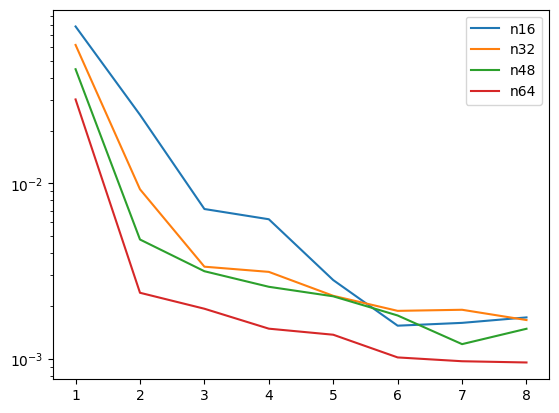

In [12]:
plt.clf()
plt.plot(cs_kappas, [r["var"] for r in cs_ret_16], label="n16")
plt.plot(cs_kappas, [r["var"] for r in cs_ret_32], label="n32")
plt.plot(cs_kappas, [r["var"] for r in cs_ret_48], label="n48")
plt.plot(cs_kappas, [r["var"] for r in cs_ret_64], label="n64")
plt.legend(loc="upper right")
plt.yscale("log")